## What does the big picture look like?
E.g. what % of everything is hybrid? What % is Gold etc?

what % of gold, closed, hybrid, bronze etc is Green?

- which publishers have the most green (this is probably going to be subject specific e.g. arXiv, pmc areas)
  - since this is a broad search, we probably can't use our publisher name-lookup. We'll just have to accept whatever publisher name is in the data. 
  - should limit green to 2018/19 since there is the drop in recent year.
 

In [1]:
import json
import os
import datetime
import numpy as np
import pandas as pd
import pymongo

In [2]:
from tools.PublisherNameConsolidator import PublisherNameConsolidator
publisher_name_consolidator = PublisherNameConsolidator().publisher_name_consolidator
publisher_dct = PublisherNameConsolidator().publisher_dct

In [3]:
# Which date range are we interested in?
# Set these variables to months in the format 'YYYY-MM'
start_month = '2010-01'
end_month = '2020-12'
assert end_month>=start_month

In [4]:
from tools.PublisherCountsByType import PublisherCountsByType
allowed_months = PublisherCountsByType().build_allowed_months(start_month, end_month)
allowed_months_set = set(allowed_months)

## Build dataset
- capture data for hybrid and gold trends both global and at the publisher level for large publishing houses.

# Build / Load the data

In [11]:
from tools.UnpaywallDataFrame import UnpaywallDataFrame
filepath = r'C:\Users\aday\OneDrive - SAGE Publishing\DATA\Unpaywall\unpaywall_snapshot_2021-02-18T160139.jsonl.gz'
from config import Config
dataframe_path = os.path.join(Config.data_dir,'unpaywall_dataframe.csv')

In [5]:
%%time

df = UnpaywallDataFrame(
    snapshot_path = filepath,
    dataframe_path = dataframe_path,
    allowed_months = allowed_months
).build_load_dataframe()
df.shape

Wall time: 307 ms


(347886, 11)

## Filtering
In case we decide that we want to change the 'allowed months', we can use this cell to filter out any months of data that we don't want to keep. 
We might also want to filter which publishers we look at. 

In [6]:
df = df[df['month'].isin(allowed_months_set)]
df.shape

(347886, 11)

## Explore the data

In [7]:
df.sample(2)

,count,subscription_count,hybrid_count,gold_count,bronze_count,green_count,bronze_green_count,gold_green_count,hybrid_green_count,publisher,month
270908,1,0,0,1,0,0,0,0,0,War Studies University,2019-08
38693,1,0,0,1,0,0,0,1,0,"Facultad Latinoamericana de Ciencias Sociales,...",2012-07


In [8]:
df.columns

Index(['count', 'subscription_count', 'hybrid_count', 'gold_count',
       'bronze_count', 'green_count', 'bronze_green_count', 'gold_green_count',
       'hybrid_green_count', 'publisher', 'month'],
      dtype='object')

In [9]:
# collapse publishers to get market totals
dfm = df[['month','count', 'subscription_count', 'hybrid_count', 'gold_count',
       'bronze_count', 'green_count', 'bronze_green_count', 'gold_green_count', 'hybrid_green_count']].groupby('month').sum()
dfm = dfm.reset_index()
dfm.head(3)

,month,count,subscription_count,hybrid_count,gold_count,bronze_count,green_count,bronze_green_count,gold_green_count,hybrid_green_count
0,2010-01,495671,289348,13802,63535,76127,50422,21353,38261,6246
1,2010-02,140418,95284,4685,7992,17023,15434,6353,4893,2096
2,2010-03,184494,120658,4947,19424,20451,19014,7817,6767,2314


# Green by any name
- I'm interested to look at growth trends _in repositories_. I'm going to call this 'Green OA'. However, Green OA is _authors' accepted manuscripts_ being posted to repositories. Strictly, this should be limited to _subscription_ content.
- We can use Unpaywall data to look at the total volume of content being posted to repositories whether it is subscription, bronze, gold or hybrid. This shows the trend in repository usage which might be obscured if we only look at a subset of the data. 
- Unpaywall does differentiate repository versions into 'submittedVersion', 'acceptedVersion' and 'publishedVersion'. To look at Green properly, it might be worth limiting to 'acceptedVersion'. I haven't done that here.

In [10]:
dfm['green_by_any_name_count'] = dfm[['green_count', 'bronze_green_count', 'gold_green_count', 'hybrid_green_count']].sum(axis=1)
dfm.shape

(132, 11)

In [11]:
df['green_by_any_name_count'] = df[['green_count', 'bronze_green_count', 'gold_green_count', 'hybrid_green_count']].sum(axis=1)
df.shape

(347886, 12)

## Visualise market-level trends

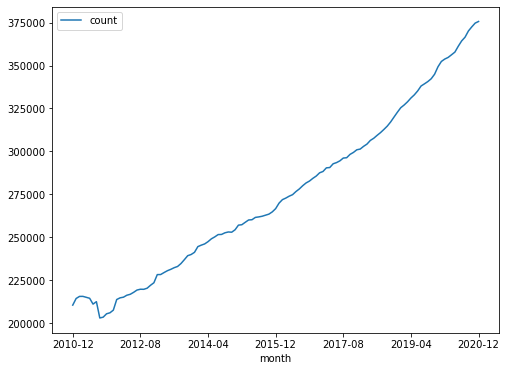

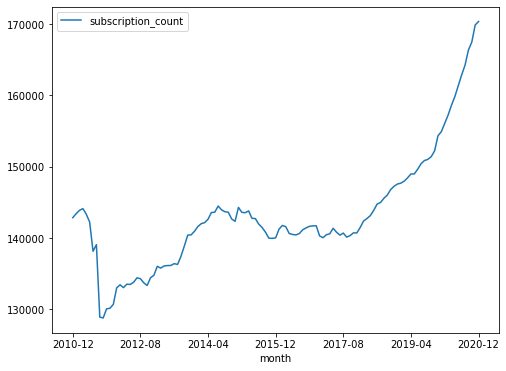

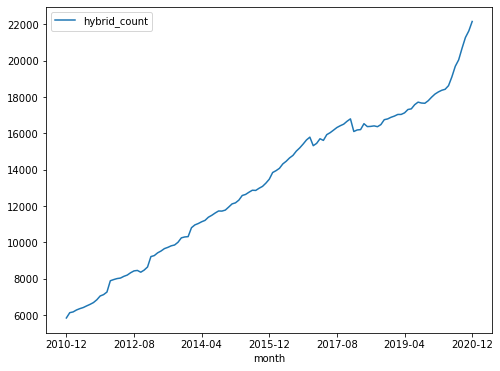

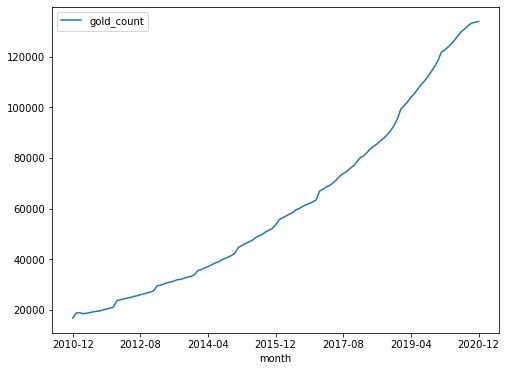

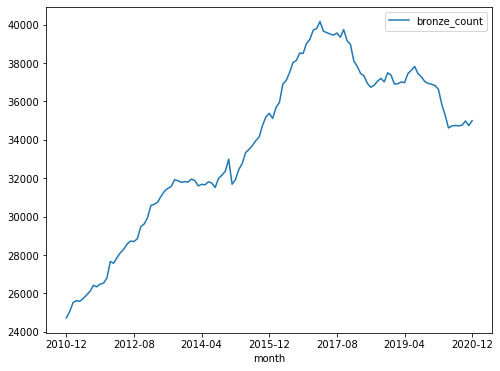

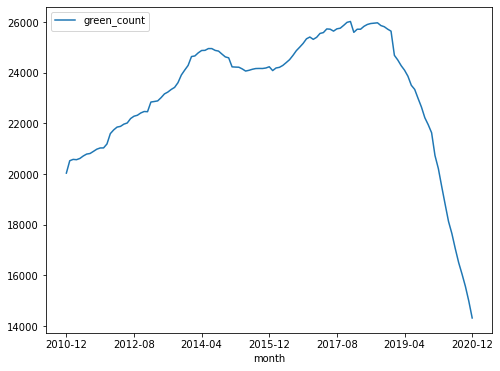

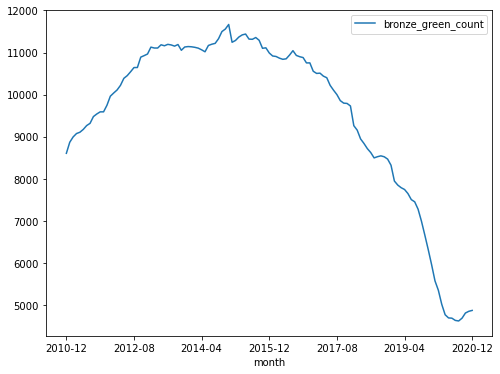

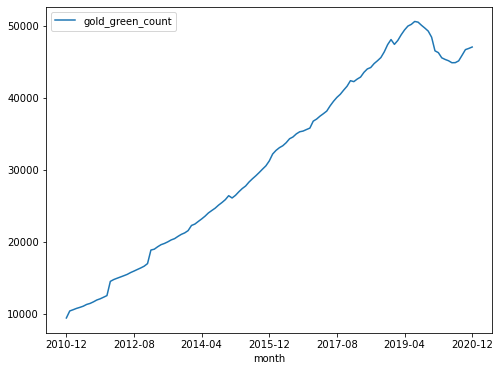

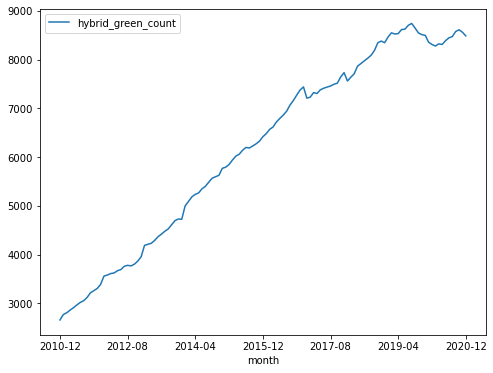

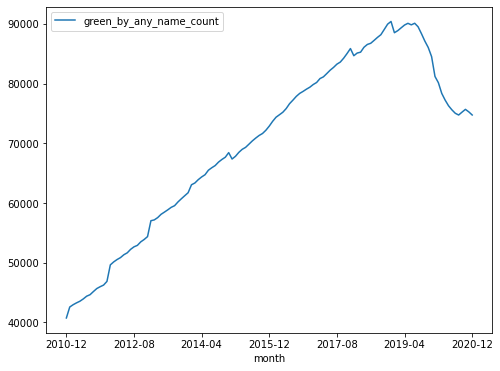

In [12]:
from matplotlib import pyplot as plt
for col in dfm.columns:
    if col not in {'month','year'}:
        win_size = 12
        df_plot = dfm[[col]]
        df_plot = df_plot.rolling(win_size,win_type=None).mean().tail(-1*(win_size-1))#.reset_index()
#         df_plot['gold_percent'] = df_plot['gold_count'] / df_plot['count']
        df_plot['month'] = dfm['month'].values[win_size-1:]
#         df_plot
        fig,ax = plt.subplots(figsize=(8,6))
        df_plot.plot('month',col, ax = ax)
        fig_path = os.path.join(Config['images_dir'],'12mo_rolling_'+col)
        plt.savefig(fig_path)

2021-03-23 15:31:27,266 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2021-03-23 15:31:27,274 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2021-03-23 15:31:27,280 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2021-03-23 15:31:27,287 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2021-03-23 15:31:27,

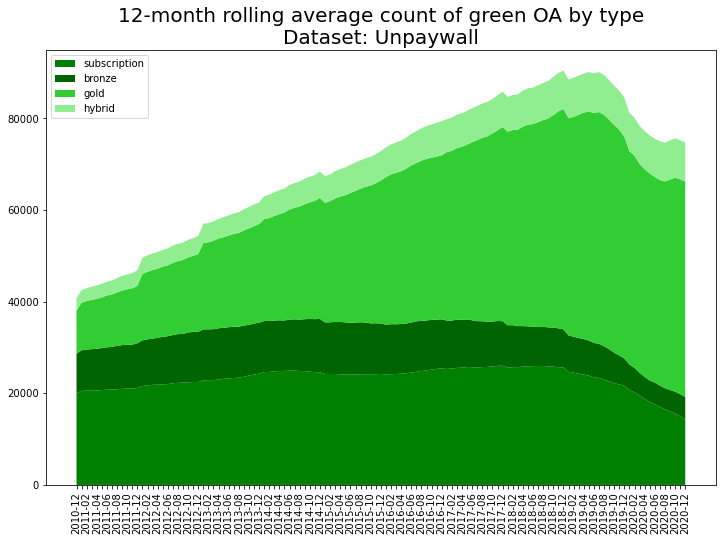

In [13]:
# stack green data
x = dfm['month'].values[win_size-1:]

y = [dfm[[col]].rolling(win_size,win_type=None).mean().tail(-1*(win_size-1))[col].to_list()
     for col in ['green_count', 'bronze_green_count', 'gold_green_count', 'hybrid_green_count']]

win_size = 12

labels = ['subscription','bronze','gold','hybrid',]
fig,ax = plt.subplots(figsize=(12,8))
plt.stackplot(x, y, labels = labels, colors = ['green','darkgreen','limegreen','lightgreen'])
fig_filename = 'stacked count of Green OA articles (including those which are also recorded as other types).png'
plt.title('12-month rolling average count of green OA by type\nDataset: Unpaywall', size = 20)
plt.legend(loc='upper left')
ax.set_xticklabels(labels = x, rotation=90)
plt.setp(ax.get_xticklabels()[1::2], visible=False)
fig_path = os.path.join(Config.images_dir,fig_filename)
plt.savefig(fig_path)

# Who is publishing the most green?


In [14]:
dfpy = df[['month', 'publisher', 'count','subscription_count', 'green_count','bronze_green_count','bronze_count', 'green_by_any_name_count' ]]
dfpy['year'] = dfpy['month'].map(lambda x: x[:4])
dfpy.pop('month')
dfpy = dfpy.groupby(['publisher','year']).sum()
dfpy = dfpy.reset_index()

# now calculate the green percentages
dfpy['green_pc'] = (dfpy['green_count'] + dfpy['bronze_green_count']) / ( dfpy['subscription_count'] + dfpy['green_count'] + dfpy['bronze_count'])
dfpy['green_any_pc'] = dfpy['green_by_any_name_count'] / dfpy['count']

dfpy.head()

<ipython-input-14-4d706252a3df>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfpy['year'] = dfpy['month'].map(lambda x: x[:4])
2021-03-23 15:31:28,378 - numexpr.utils - INFO - Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2021-03-23 15:31:28,379 - numexpr.utils - INFO - NumExpr defaulting to 8 threads.


,publisher,year,count,subscription_count,green_count,bronze_green_count,bronze_count,green_by_any_name_count,green_pc,green_any_pc
0,21st Century Political Science Association,2010,42,1,0,0,0,0,0.0,0.0
1,21st Century Political Science Association,2011,38,0,0,0,0,0,NaN,0.0
2,21st Century Political Science Association,2012,51,2,0,0,0,0,0.0,0.0
3,21st Century Political Science Association,2013,38,2,0,0,0,0,0.0,0.0
4,21st Century Political Science Association,2014,55,0,0,0,0,0,NaN,0.0


## Which publishers are publishing the most Green OA?
This list shows the top publishers publishing Green OA content. Green figures seem to peak in 2017-2018, so we are ordering by that time-period.

In [15]:
green = dfpy.pivot(index='year',columns='publisher', values='green_by_any_name_count').T
green = green.dropna()
green = green.sort_values('2018', ascending = False)
top_n = green.head(30).index
green.head(30)

year,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
publisher,,,,,,,,,,,
Springer,58285.0,65350.0,71043.0,82410.0,91325.0,104777.0,114335.0,122216.0,122107.0,124236.0,132135.0
Elsevier,64351.0,70182.0,73621.0,78062.0,86016.0,95673.0,105372.0,111234.0,115705.0,111668.0,112832.0
MDPI,4840.0,5229.0,7633.0,9751.0,12626.0,17684.0,23614.0,36494.0,59956.0,84601.0,108066.0
Wiley,30122.0,29249.0,30175.0,33173.0,37278.0,40737.0,45941.0,51289.0,56174.0,56761.0,53659.0
OUP,22476.0,23885.0,25593.0,27039.0,30459.0,29008.0,27719.0,34487.0,37358.0,37287.0,31855.0
T+F,13837.0,15601.0,17466.0,23464.0,23928.0,26452.0,32700.0,33016.0,33770.0,32201.0,24045.0
Frontiers Media SA,1204.0,2449.0,5061.0,7459.0,11145.0,12809.0,15103.0,20613.0,28508.0,32435.0,43723.0
Public Library of Science (PLoS),9297.0,16653.0,27111.0,36479.0,35447.0,33536.0,26712.0,24568.0,22180.0,19632.0,20415.0
EDP Sciences,4359.0,3892.0,4874.0,5810.0,5964.0,6162.0,10967.0,12299.0,19981.0,14353.0,6154.0


## Whose content has the highest overlap with repositories?

In [16]:
# look at 'green_pc' i.e. percent of content that is subscription content in a repository
pc = 100*dfpy[dfpy['publisher'].isin(set(top_n))].pivot(index='year',columns='publisher', values='green_pc').T
def f(x):
    return round(x,2)
# drop all rows with NaNs in them
pc = pc.dropna()
# Drop MDPI since they should be 100% Gold
pc = pc.drop('MDPI')
# sort by the 2020 column
pc = pc.sort_values('2020', ascending = False)
pc.apply(f).head(30)

year,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
publisher,,,,,,,,,,,
American Astronomical Society,88.04,87.95,89.48,89.66,89.29,89.64,91.46,90.57,88.63,86.50,84.04
American Physical Society (APS),73.78,71.15,73.60,76.76,78.42,76.78,78.61,78.30,76.13,74.76,72.54
Proceedings of the National Academy of Sciences,99.91,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,70.47
EDP Sciences,76.65,74.71,75.78,72.47,75.88,74.56,74.18,71.70,72.81,67.14,59.65
American Society for Microbiology,95.33,95.88,95.46,94.09,94.66,93.45,91.80,99.04,99.70,98.63,54.71
IOP Publishing,30.41,29.25,29.46,32.77,31.65,32.78,33.33,32.86,29.67,24.14,23.40
AIP Publishing,34.19,34.73,34.71,34.87,34.67,36.02,38.21,38.58,37.74,32.75,23.21
Medknow,51.72,53.55,47.24,48.68,43.65,36.45,35.49,31.40,26.76,26.30,20.99
"Scientific Research Publishing, Inc.",65.72,78.61,88.10,90.53,80.90,89.29,83.79,71.08,31.07,0.00,16.67


In [17]:
# now look at what % of content is in a repository generally (not just subscription content)
# this shows a lot of automated Gold OA being backed up in repositories. E.g. https://pubrouter.jisc.ac.uk/
pc = 100*dfpy[dfpy['publisher'].isin(set(top_n))].pivot(index='year',columns='publisher', values='green_any_pc').T
def f(x):
    return round(x,2)
pc = pc.dropna()
pc = pc.sort_values('2020', ascending = False)
pc.apply(f).head(30)

year,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
publisher,,,,,,,,,,,
Public Library of Science (PLoS),99.26,99.81,100.00,99.95,99.97,99.91,99.95,100.00,99.99,99.99,99.97
Frontiers Media SA,36.00,64.43,82.87,80.72,93.29,87.94,77.19,98.21,96.72,95.33,90.67
Spandidos Publications,82.95,87.45,91.27,93.49,92.64,93.28,91.64,90.93,85.03,84.47,89.38
American Astronomical Society,88.05,87.94,89.48,89.67,89.30,89.62,91.47,90.53,88.80,86.47,83.13
Proceedings of the National Academy of Sciences,99.91,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,80.80
American Physical Society (APS),73.57,74.60,76.76,78.27,78.91,80.87,82.32,81.69,81.86,79.66,77.53
American Society for Microbiology,95.62,96.37,95.92,95.29,96.06,95.45,94.97,99.44,99.79,99.30,76.78
Copernicus GmbH,94.26,92.30,92.89,94.32,96.07,95.22,79.42,95.46,93.34,79.44,67.88
MDPI,97.82,95.98,97.32,98.20,98.18,98.06,97.51,95.26,88.44,76.91,65.40


In [18]:
cols = ['subscription_count', 'hybrid_count', 'gold_count',
       'bronze_count', 'green_count',
       'bronze_green_count', 'gold_green_count', 'hybrid_green_count','green_by_any_name_count']
for col in cols:
    pc_col_name = col[:-5] + 'percent'
    dfm[pc_col_name] = dfm[col] / dfm['count']

dfm.head(2)


,month,count,subscription_count,hybrid_count,gold_count,bronze_count,green_count,bronze_green_count,gold_green_count,hybrid_green_count,green_by_any_name_count,subscription_percent,hybrid_percent,gold_percent,bronze_percent,green_percent,bronze_green_percent,gold_green_percent,hybrid_green_percent,green_by_any_name_percent
0,2010-01,495671,289348,13802,63535,76127,50422,21353,38261,6246,116282,0.583750,0.027845,0.128180,0.153584,0.101725,0.043079,0.077190,0.012601,0.234595
1,2010-02,140418,95284,4685,7992,17023,15434,6353,4893,2096,28776,0.678574,0.033365,0.056916,0.121231,0.109915,0.045243,0.034846,0.014927,0.204931


In [19]:
cols = ['subscription_count', 'hybrid_count', 'gold_count',
       'bronze_count', 'green_count',
       'bronze_green_count', 'gold_green_count', 'hybrid_green_count','green_by_any_name_count']
for col in cols:
    pc_col_name = col[:-5] + 'percent'
    dfm[pc_col_name] = dfm[col] / dfm['count']

dfm.head(2)

,month,count,subscription_count,hybrid_count,gold_count,bronze_count,green_count,bronze_green_count,gold_green_count,hybrid_green_count,green_by_any_name_count,subscription_percent,hybrid_percent,gold_percent,bronze_percent,green_percent,bronze_green_percent,gold_green_percent,hybrid_green_percent,green_by_any_name_percent
0,2010-01,495671,289348,13802,63535,76127,50422,21353,38261,6246,116282,0.583750,0.027845,0.128180,0.153584,0.101725,0.043079,0.077190,0.012601,0.234595
1,2010-02,140418,95284,4685,7992,17023,15434,6353,4893,2096,28776,0.678574,0.033365,0.056916,0.121231,0.109915,0.045243,0.034846,0.014927,0.204931


# Gold and Hybrid as markets
If we imagine that Gold OA is a market in itself, which publishers are publishing the most papers from that market? Who has a growing market share?

Same for Hybrid

In [20]:
df= df[['month', 'publisher', 'count','subscription_count', 'hybrid_count', 'gold_count',
       'bronze_count', 'green_count', 
       'bronze_green_count', 'gold_green_count', 'hybrid_green_count']]
df.shape

(347886, 11)

In [21]:
dfm.head()

,month,count,subscription_count,hybrid_count,gold_count,bronze_count,green_count,bronze_green_count,gold_green_count,hybrid_green_count,green_by_any_name_count,subscription_percent,hybrid_percent,gold_percent,bronze_percent,green_percent,bronze_green_percent,gold_green_percent,hybrid_green_percent,green_by_any_name_percent
0,2010-01,495671,289348,13802,63535,76127,50422,21353,38261,6246,116282,0.583750,0.027845,0.128180,0.153584,0.101725,0.043079,0.077190,0.012601,0.234595
1,2010-02,140418,95284,4685,7992,17023,15434,6353,4893,2096,28776,0.678574,0.033365,0.056916,0.121231,0.109915,0.045243,0.034846,0.014927,0.204931
2,2010-03,184494,120658,4947,19424,20451,19014,7817,6767,2314,35912,0.653994,0.026814,0.105283,0.110849,0.103060,0.042370,0.036679,0.012542,0.194651
3,2010-04,173729,122098,4725,10648,19044,17204,7052,6007,2312,32575,0.702807,0.027198,0.061291,0.109619,0.099028,0.040592,0.034577,0.013308,0.187505
4,2010-05,182059,133781,4608,9166,18124,16380,6842,5889,1968,31079,0.734822,0.025310,0.050346,0.099550,0.089971,0.037581,0.032347,0.010810,0.170708


In [22]:
# Calculate the percent of each market that each publisher is publishing each month. 
hybrid_pcs = []
gold_pcs = []
for i,row in df.iterrows():
    # each row represents a publisher in 1 month
    hybrid_count = row['hybrid_count']
    gold_count = row['gold_count']
    month = row['month']
    # this row represents the entire market in the same month
    dfm_row = dfm[dfm['month']==month]
    gold_total = dfm_row['gold_count']#[0]
    hybrid_total = dfm_row['hybrid_count']#[0]
    # hybrid percent here is the percent of the TOTAL count that is hybrid for this publisher this month
    hybrid_pc = float(hybrid_count / hybrid_total)
    gold_pc = float(gold_count / gold_total)
    hybrid_pcs.append(hybrid_pc)
    gold_pcs.append(gold_pc)
df['hybrid_pc'] = hybrid_pcs
df['gold_pc'] = gold_pcs
df.head()

,month,publisher,count,subscription_count,hybrid_count,gold_count,bronze_count,green_count,bronze_green_count,gold_green_count,hybrid_green_count,hybrid_pc,gold_pc
0,2010-01,Centennial Library,6,0,0,6,0,0,0,3,0,0.000000,0.000094
1,2010-01,"Acta Physica Sinica, Chinese Physical Society ...",1366,8,1358,0,0,0,0,0,0,0.098392,0.000000
2,2010-01,The Japanese Society for Oral Pathology,17,0,0,0,17,0,3,0,0,0.000000,0.000000
3,2010-01,Elementary Education Research Institute,12,0,12,0,0,0,0,0,0,0.000869,0.000000
4,2010-01,Western Australian Museum,26,0,0,0,26,0,5,0,0,0.000000,0.000000


In [23]:
# summarise by year
# drop pc columns, because you have to recalculate those!

dfmy = df[['month', 'publisher', 'subscription_count', 'hybrid_count', 'gold_count',
       'bronze_count', 'green_count',
       'bronze_green_count', 'gold_green_count', 'hybrid_green_count']]
dfmy['year'] = dfmy['month'].map(lambda x: x[:4])
dfmy.pop('month')
dfmy = dfmy.groupby(['publisher','year']).sum()
dfmy = dfmy.reset_index()

# now recalculate the hybrid and gold percentages

dfm['year'] = dfm['month'].map(lambda x: x[:4])

hybrid_pcs = []
gold_pcs = []
for i,row in dfmy.iterrows():
    # each row represents a publisher in 1 month
    hybrid_count = row['hybrid_count']
    gold_count = row['gold_count']
    year = row['year']
    # this row represents the entire market in the same month
    dfm_row = dfm[dfm['year']==year]
    gold_total = dfm_row['gold_count'].sum()#[0]
    hybrid_total = dfm_row['hybrid_count'].sum()#[0]
    # hybrid percent here is the percent of the TOTAL count that is hybrid for this publisher this month
    hybrid_pc = float(hybrid_count / hybrid_total)
    gold_pc = float(gold_count / gold_total)
    hybrid_pcs.append(hybrid_pc)
    gold_pcs.append(gold_pc)
dfmy['hybrid_pc'] = hybrid_pcs
dfmy['gold_pc'] = gold_pcs

dfmy.head()

<ipython-input-23-65c3cd7374df>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfmy['year'] = dfmy['month'].map(lambda x: x[:4])


,publisher,year,subscription_count,hybrid_count,gold_count,bronze_count,green_count,bronze_green_count,gold_green_count,hybrid_green_count,hybrid_pc,gold_pc
0,21st Century Political Science Association,2010,1,41,0,0,0,0,0,0,0.000585,0.000000
1,21st Century Political Science Association,2011,0,38,0,0,0,0,0,0,0.000436,0.000000
2,21st Century Political Science Association,2012,2,49,0,0,0,0,0,0,0.000472,0.000000
3,21st Century Political Science Association,2013,2,36,0,0,0,0,0,0,0.000291,0.000000
4,21st Century Political Science Association,2014,0,0,55,0,0,0,0,0,0.000000,0.000108


## Examine the data

In [25]:
def make_df_plot(dfmy, column = 'gold_percent', drop_other=True):
    years = [str(x) for x in range(2010,2021)]
    df_plot = dfmy.pivot(index='publisher', columns='year', values=column)
    df_plot = df_plot[years].T
    if drop_other==True:
        # drop 'Other'
        df_plot = df_plot[['CUP', 'Elsevier', 'OUP', 'SAGE', 'Springer', 'T+F', 'Wiley','MDPI']]
    return df_plot

In [26]:
# # present with years as cols and publishers as index
# pc=100*make_df_plot(dfmy, column = 'green_by_any_name_percent', drop_other=False).T.sort_values('2020')
# pc.drop('MDPI', axis='index', inplace=True)
# def f(x):
#     return round(x,2)
    
# pc = pc.apply(f)
# pc = pc.dropna()
# pc.tail(20)

# Gold and Hybrid

In [27]:
# # check columns sum to 1 (they do)
# dfmy.pivot(index='publisher', columns='year', values='hybrid_pc')[[str(x) for x in range(2014,2021)]].sum()

In [28]:
tbl = make_df_plot(dfmy, column = 'hybrid_count', drop_other=False).T.sort_values('2020', ascending = False)
tbl.dropna()
tbl.drop('MDPI', axis='index', inplace=True)
tbl

year,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
publisher,,,,,,,,,,,
Elsevier,12327.0,14311.0,16997.0,21473.0,25281.0,25729.0,29575.0,26824.0,29211.0,32297.0,46682.0
Springer,8727.0,9732.0,9206.0,9694.0,10956.0,12589.0,15936.0,17434.0,20225.0,22980.0,35444.0
Wiley,141.0,234.0,285.0,2367.0,4622.0,5994.0,10608.0,14711.0,19288.0,25063.0,32398.0
OUP,2671.0,2691.0,2962.0,3409.0,3721.0,3621.0,4429.0,4931.0,6858.0,6798.0,9302.0
SAGE,188.0,225.0,280.0,426.0,453.0,691.0,1261.0,1999.0,2100.0,2898.0,6921.0
...,...,...,...,...,...,...,...,...,...,...,...
iMedPharm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
ibidem-Verlag,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0,NaN,0.0,NaN
mEDRA,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
pc = 100*make_df_plot(dfmy, column = 'gold_pc', drop_other=False).T.sort_values('2020', ascending = False)
def f(x):
    return round(x,2)
    
pc.apply(f).head(20)

year,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
publisher,,,,,,,,,,,
MDPI,2.37,2.09,2.30,2.39,2.49,2.77,3.15,4.06,5.90,7.73,10.26
Springer,12.61,11.42,9.90,10.25,10.30,10.25,9.32,8.26,6.70,5.90,6.03
Elsevier,4.95,7.34,7.84,5.23,6.71,7.28,5.73,5.03,3.81,3.91,4.74
IOP Publishing,0.46,0.37,0.34,1.57,1.61,1.47,1.70,2.62,3.61,4.61,4.65
Frontiers Media SA,1.62,1.49,1.82,2.27,2.33,2.27,2.57,2.23,2.58,2.39,3.00
Wiley,0.64,1.06,0.88,0.94,1.12,1.09,1.08,1.13,1.18,1.30,1.61
Hindawi Limited,3.35,4.97,7.01,6.48,5.71,3.43,2.47,1.81,1.87,1.34,1.55
T+F,1.86,1.56,1.71,1.76,1.72,1.63,1.82,1.62,1.50,1.40,1.45
Public Library of Science (PLoS),4.64,6.58,8.16,8.98,6.95,5.22,3.51,2.61,1.94,1.38,1.27


In [30]:
# dfmy.pivot(index='publisher', columns='year', values='gold_pc')[[str(x) for x in range(2015,2021)]].sum()

In [40]:
make_df_plot(dfmy, column = 'gold_count', drop_other=False).T.sort_values('2020', ascending = False)

year,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
publisher,,,,,,,,,,,
MDPI,4780.0,5287.0,7629.0,9724.0,12690.0,17836.0,23971.0,38254.0,67560.0,109809.0,164797.0
Springer,25459.0,28964.0,32861.0,41662.0,52522.0,65912.0,71024.0,77778.0,76676.0,83910.0,96921.0
Elsevier,9990.0,18608.0,26029.0,21275.0,34215.0,46799.0,43685.0,47340.0,43652.0,55512.0,76098.0
IOP Publishing,927.0,927.0,1115.0,6403.0,8215.0,9424.0,12968.0,24707.0,41312.0,65512.0,74666.0
Frontiers Media SA,3269.0,3766.0,6050.0,9215.0,11897.0,14560.0,19567.0,20989.0,29476.0,34023.0,48221.0
...,...,...,...,...,...,...,...,...,...,...,...
iMedPharm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.0,6.0,NaN,NaN
ibidem-Verlag,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,1.0,NaN
mEDRA,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


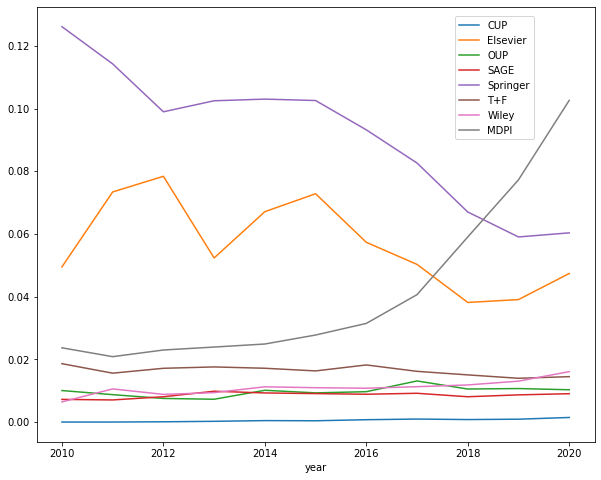

In [32]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,8))
df_plot = make_df_plot(dfmy, column = 'gold_pc', drop_other=True)
df_plot.plot(ax=ax)
ax.legend(loc='upper right', bbox_to_anchor=(0.9,0.99))
# ax.set_yscale('log')

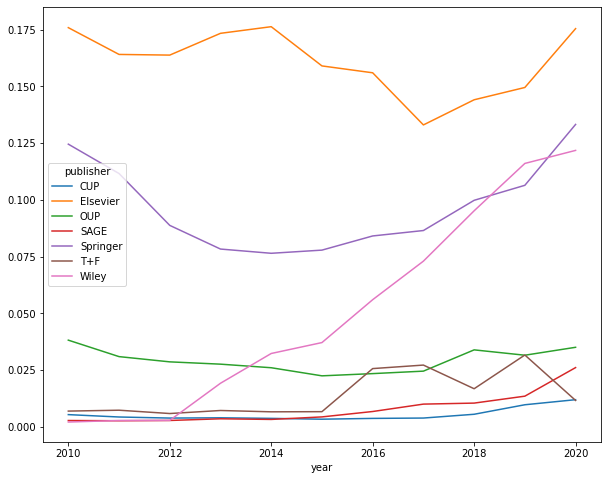

In [33]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,8))
df_plot = make_df_plot(dfmy, column = 'hybrid_pc', drop_other=True)
df_plot = df_plot.drop('MDPI', axis=1)
df_plot.plot(ax=ax)
# ax.set_yscale('log')

# Potential issues
- expect Elsevier's numbers to be more consistent than this seem to go up and down too much
- can you confirm some of these numbers by looking at publishers' websites?

In [34]:
specific_publisher = 'Elsevier'
win_size = 12
df_plot = df[df['publisher']==specific_publisher][['count','gold_count']]
df_plot = df_plot.rolling(win_size,win_type=None).sum().tail(-1*(win_size-1))#.reset_index()
df_plot['gold_percent'] = df_plot['gold_count'] / df_plot['count']
df_plot['month'] = dfm['month'].values[win_size-1:]
df_plot

,count,gold_count,gold_percent,month
12343,500252.0,9990.0,0.019970,2010-12
14397,511632.0,19631.0,0.038369,2011-01
16049,516923.0,19653.0,0.038019,2011-02
17043,516419.0,18745.0,0.036298,2011-03
17941,514930.0,18555.0,0.036034,2011-04
...,...,...,...,...
325468,762850.0,63232.0,0.082889,2020-08
329803,773198.0,64282.0,0.083138,2020-09
334646,779318.0,66596.0,0.085454,2020-10
337334,802510.0,70608.0,0.087984,2020-11


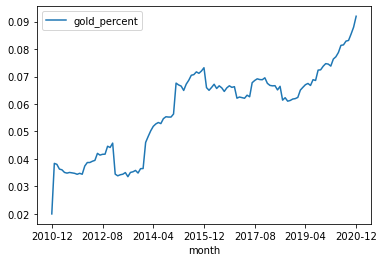

In [35]:
df_plot.plot('month','gold_percent')

In [36]:
win_size = 24
df_plot = df[df['publisher']==specific_publisher][['count','hybrid_count']]
df_plot = df_plot.rolling(win_size,win_type=None).sum().tail(-1*(win_size-1))#.reset_index()
df_plot['hybrid_percent'] = df_plot['hybrid_count'] / df_plot['count']
df_plot['month'] = dfm['month'].values[win_size-1:]
df_plot

,count,hybrid_count,hybrid_percent,month
28139,1040850.0,26638.0,0.025593,2011-12
28975,1061715.0,28179.0,0.026541,2012-01
31394,1065850.0,28334.0,0.026583,2012-02
32815,1068703.0,28807.0,0.026955,2012-03
34723,1070545.0,28785.0,0.026888,2012-04
...,...,...,...,...
325468,1496792.0,67916.0,0.045374,2020-08
329803,1507912.0,70502.0,0.046755,2020-09
334646,1517313.0,72992.0,0.048106,2020-10
337334,1541090.0,75535.0,0.049014,2020-11


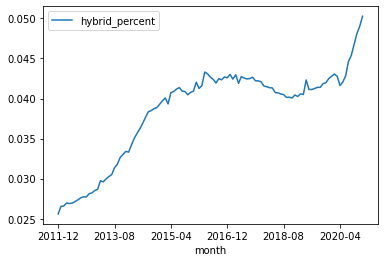

In [37]:
df_plot.plot('month','hybrid_percent')